In [1]:
import kagglehub
from pathlib import Path
import pandas as pd 
import numpy as np
import torch
import shap
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


In [2]:
path = kagglehub.dataset_download("columbine/imdb-dataset-sentiment-analysis-in-csv-format")
path = Path(path)
test_df = pd.read_csv(path / "Test.csv")
train_df = pd.read_csv(path / "Train.csv")
train_df.head(5)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [3]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)
model.eval()

BATCH_SIZE = 32

def get_embeddings_batch(texts_batch, model, tokenizer, device):
    """
    Generates BERT embeddings for a batch of texts.
    """
    inputs = tokenizer(
        texts_batch, 
        return_tensors='pt', 
        padding=True,
        truncation=True,
        max_length=256
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    
    return cls_embeddings.cpu().detach().numpy()

all_embeddings_list = []

if 'train_df' in globals() and isinstance(train_df, pd.DataFrame) and not train_df.empty:
    print(f"Processing train_df with {len(train_df)} texts...")
    if 'text' not in train_df.columns:
        print("Warning: 'text' column not found in train_df. Skipping train_df processing.")
    else:
        train_texts = train_df['text'].tolist()
        for i in tqdm(range(0, len(train_texts), BATCH_SIZE), desc="Embedding Train Batches"):
            batch_texts = train_texts[i:i+BATCH_SIZE]
            if batch_texts:
                batch_embeddings = get_embeddings_batch(batch_texts, model, tokenizer, device)
                all_embeddings_list.extend(batch_embeddings)
else:
    print("train_df is not defined, not a DataFrame, or is empty. Skipping train_df processing.")

if 'test_df' in globals() and isinstance(test_df, pd.DataFrame) and not test_df.empty:
    print(f"\nProcessing test_df with {len(test_df)} texts...")
    if 'text' not in test_df.columns:
        print("Warning: 'text' column not found in test_df. Skipping test_df processing.")
    else:
        test_texts = test_df['text'].tolist()
        for i in tqdm(range(0, len(test_texts), BATCH_SIZE), desc="Embedding Test Batches"):
            batch_texts = test_texts[i:i+BATCH_SIZE]
            if batch_texts:
                batch_embeddings = get_embeddings_batch(batch_texts, model, tokenizer, device)
                all_embeddings_list.extend(batch_embeddings)
else:
    print("\ntest_df is not defined, not a DataFrame, or is empty. Skipping test_df processing.")

if all_embeddings_list:
    final_embeddings_array = np.array(all_embeddings_list)
    print(f"\nGenerated embeddings of shape: {final_embeddings_array.shape}")
    np.save('bert_embeddings.npy', final_embeddings_array)
    print("Embeddings saved to 'bert_embeddings.npy'")
else:
    print("\nNo embeddings were generated as DataFrames were empty, did not exist, or contained no 'text' data.")


Using device: cuda
Processing train_df with 40000 texts...


Embedding Train Batches: 100%|██████████| 1250/1250 [22:49<00:00,  1.10s/it]



Processing test_df with 5000 texts...


Embedding Test Batches: 100%|██████████| 157/157 [02:53<00:00,  1.11s/it]



Generated embeddings of shape: (45000, 768)
Embeddings saved to 'bert_embeddings.npy'


Using device: cuda
Successfully loaded 'bert_embeddings.npy' with shape: (45000, 768)
Raw train embeddings shape: (40000, 768)
Raw test embeddings shape: (5000, 768)

Scaling features (embeddings)...
Feature scaling complete.

Created DataLoaders with batch size: 64

PyTorch MLP Model:
SentimentMLP(
  (fc1): Linear(in_features=768, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Starting training for 25 epochs...
Epoch [1/25], Train Acc: 78.40%, Val Acc: 84.58%
Epoch [2/25], Train Acc: 83.89%, Val Acc: 84.78%
Epoch [3/25], Train Acc: 84.23%, Val Acc: 85.20%
Epoch [4/25], Train Acc: 84.60%, Val Acc: 85.02%
Epoch [5/25], Train Acc: 84.92%, Val Acc: 85.30%
Epoch [6/25], Train Acc: 85.28%, Val Acc: 85.06%
Epoch [7/25], Train Acc: 85.27%, Val Acc: 85.32%
Epoch [8/25], 

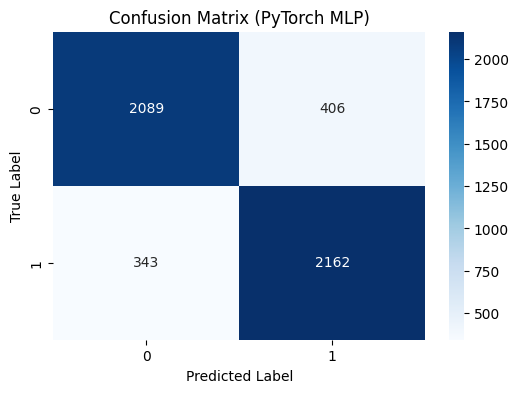

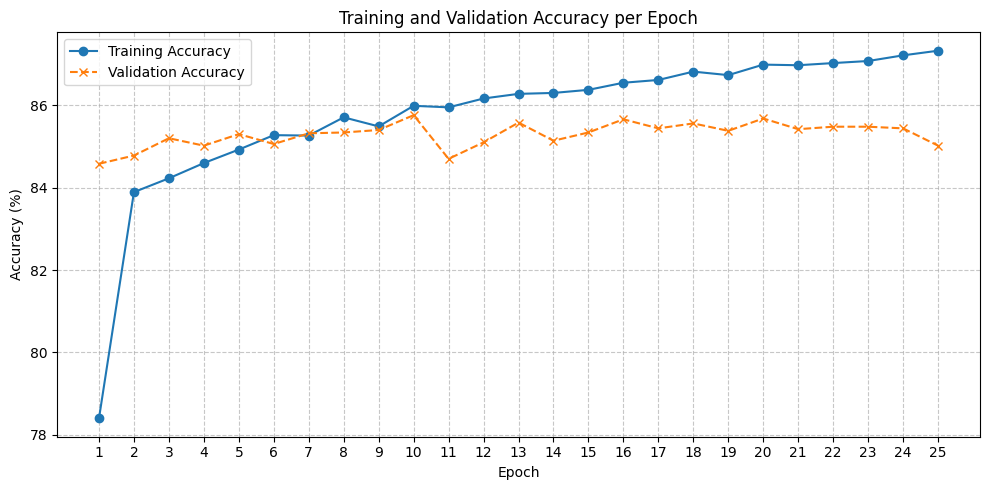


--- PyTorch MLP Classification Example End ---


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler # To ensure we have scaled embeddings
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Load your pre-computed embeddings (same as before) ---
try:
    all_embeddings = np.load('bert_embeddings.npy')
    print(f"Successfully loaded 'bert_embeddings.npy' with shape: {all_embeddings.shape}")
except FileNotFoundError:
    print("Error: 'bert_embeddings.npy' not found.")
    exit()
except Exception as e:
    print(f"Error loading 'bert_embeddings.npy': {e}")
    exit()

# --- 2. Load your original DataFrames to get labels (same as before) ---
if 'train_df' not in globals() or not isinstance(train_df, pd.DataFrame) or 'label' not in train_df.columns:
    print("Warning: 'train_df' with 'label' column not found. Creating dummy for demonstration.")
    num_dummy_train_samples = int(all_embeddings.shape[0] * 0.75) if all_embeddings.shape[0] > 0 else 10
    train_df = pd.DataFrame({'label': np.random.randint(0, 2, num_dummy_train_samples)})
if 'test_df' not in globals() or not isinstance(test_df, pd.DataFrame) or 'label' not in test_df.columns:
    print("Warning: 'test_df' with 'label' column not found. Creating dummy for demonstration.")
    num_dummy_test_samples = all_embeddings.shape[0] - len(train_df) if all_embeddings.shape[0] > len(train_df) else 10
    if num_dummy_test_samples <=0 : num_dummy_test_samples = 10
    test_df = pd.DataFrame({'label': np.random.randint(0, 2, num_dummy_test_samples)})

# --- 3. Prepare Labels and Split Embeddings (same as before) ---
if 'label' not in train_df.columns or 'label' not in test_df.columns:
    print("Error: 'label' column is missing. Cannot proceed.")
    exit()
num_train_samples = len(train_df)
train_embeddings_np = all_embeddings[:num_train_samples]
test_embeddings_np = all_embeddings[num_train_samples:]
train_labels_np = train_df['label'].values
test_labels_np = test_df['label'].values

if train_embeddings_np.shape[0] != train_labels_np.shape[0] or \
   test_embeddings_np.shape[0] != test_labels_np.shape[0] or \
   train_embeddings_np.shape[0] == 0 or test_embeddings_np.shape[0] == 0:
    print("Error: Mismatch in data shapes or empty data. Check data preparation.")
    exit()
    
print(f"Raw train embeddings shape: {train_embeddings_np.shape}")
print(f"Raw test embeddings shape: {test_embeddings_np.shape}")

# --- 4. Feature Scaling (Important for NNs) ---
print("\nScaling features (embeddings)...")
scaler = StandardScaler()
train_embeddings_scaled_np = scaler.fit_transform(train_embeddings_np)
test_embeddings_scaled_np = scaler.transform(test_embeddings_np)
print("Feature scaling complete.")

# --- 5. Convert data to PyTorch Tensors ---
X_train_tensor = torch.tensor(train_embeddings_scaled_np, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels_np, dtype=torch.long)
X_test_tensor = torch.tensor(test_embeddings_scaled_np, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels_np, dtype=torch.long)

# --- 6. Create PyTorch Datasets and DataLoaders ---
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"\nCreated DataLoaders with batch size: {BATCH_SIZE}")

# --- 7. Define the MLP Model (Same as before) ---
class SentimentMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate=0.5):
        super(SentimentMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

INPUT_DIM = X_train_tensor.shape[1]
HIDDEN_DIM1 = 32
HIDDEN_DIM2 = 16
OUTPUT_DIM = 2
DROPOUT_RATE = 0.5
model = SentimentMLP(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, OUTPUT_DIM, DROPOUT_RATE).to(device)
print("\nPyTorch MLP Model:")
print(model)

# --- 8. Define Loss Function and Optimizer (Same as before) ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# --- 9. Training Loop ---
NUM_EPOCHS = 25
train_accuracies = []
val_accuracies = [] 

print(f"\nStarting training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train() 
    epoch_train_correct = 0
    epoch_train_total = 0

    for i, (embeddings_batch, labels_batch) in enumerate(train_loader):
        embeddings_batch = embeddings_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy for the batch
        _, predicted_train = torch.max(outputs.data, 1)
        epoch_train_total += labels_batch.size(0)
        epoch_train_correct += (predicted_train == labels_batch).sum().item()

    
    current_epoch_train_accuracy = 100 * epoch_train_correct / epoch_train_total
    train_accuracies.append(current_epoch_train_accuracy)
    
    model.eval() 
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for embeddings_batch, labels_batch in test_loader: 
            embeddings_batch = embeddings_batch.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(embeddings_batch)
            _, predicted_val = torch.max(outputs.data, 1)
            val_total += labels_batch.size(0)
            val_correct += (predicted_val == labels_batch).sum().item()
    
    current_epoch_val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(current_epoch_val_accuracy)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Acc: {current_epoch_train_accuracy:.2f}%, Val Acc: {current_epoch_val_accuracy:.2f}%")


print("Training finished.")

# --- 10. Evaluation (Same as before for metrics, plot will change) ---
model.eval() 
all_preds = []
all_labels = []

with torch.no_grad():
    for embeddings_batch, labels_batch in test_loader:
        embeddings_batch = embeddings_batch.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(embeddings_batch)
        _, predicted_classes = torch.max(outputs.data, 1)
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy (PyTorch MLP): {accuracy:.4f}")
print("\nClassification Report (PyTorch MLP):")
print(classification_report(all_labels, all_preds))
print("\nConfusion Matrix (PyTorch MLP):")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (PyTorch MLP)')
plt.show()

# Plot training and validation ACCURACY
plt.figure(figsize=(10,5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, marker='x', linestyle='--', label='Validation Accuracy')
plt.title("Training and Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("\n--- PyTorch MLP Classification Example End ---")


Model is on device: cuda and in evaluation mode.
Summarizing background data (40000 samples) using shap.kmeans...
Background data summarized to 50 samples.
Preparing to explain 5 instances from the test set.

Initializing SHAP KernelExplainer...
Calculating SHAP values for 5 instances...


  0%|          | 0/5 [00:00<?, ?it/s]

SHAP values calculated.

--- Visualizing SHAP Explanations for 'Positive' Class (Index 1) ---

Generating SHAP Summary Plot...


<Figure size 640x480 with 0 Axes>

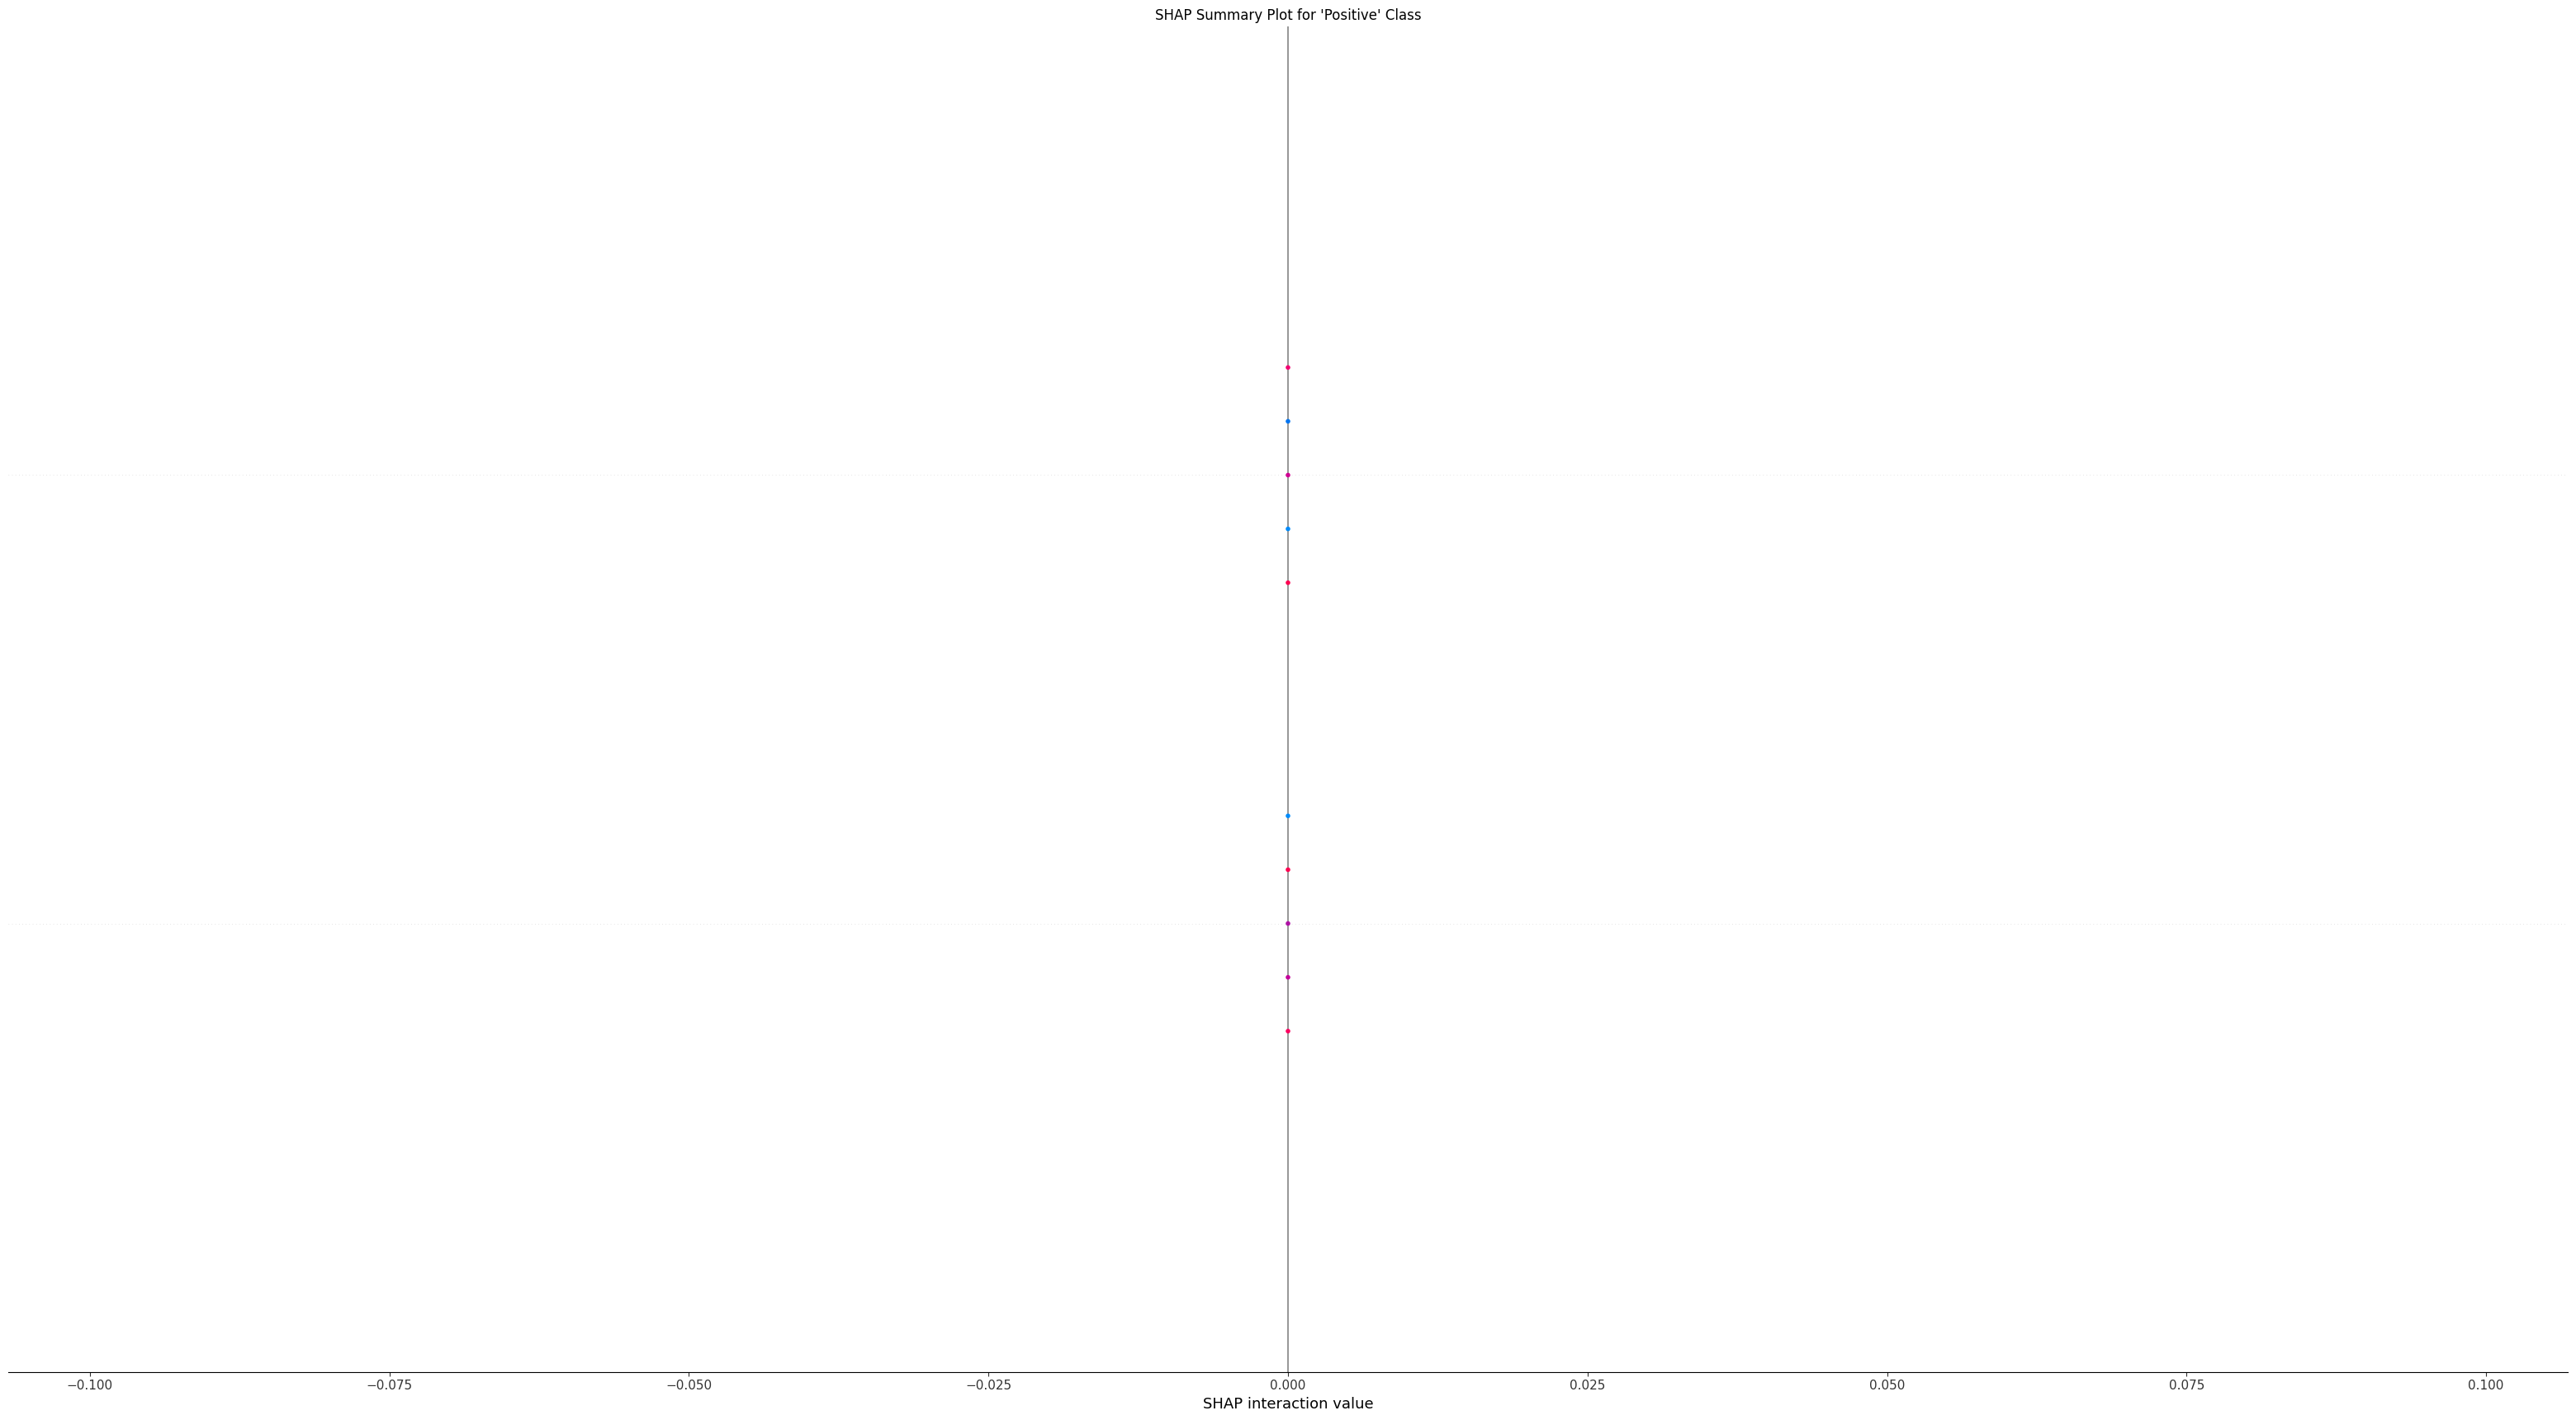


Generating SHAP Waterfall Plot for the first explained instance...


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (768, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [6]:
import shap
import numpy as np
import torch
import pandas as pd # For creating DataFrames for SHAP's feature display if needed
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plots

# --- Ensure the model is on the correct device and in evaluation mode ---
# (Assuming 'model' is your trained PyTorch SentimentMLP from the previous cell,
#  and 'device' is also defined from the previous cell.)
if 'model' not in globals() or 'device' not in globals():
    print("Error: 'model' or 'device' not found. Please ensure your PyTorch model and device are loaded from the previous cell.")
    # You might need to re-run the model definition and loading of best weights if the kernel was restarted.
    exit()

model.to(device)
model.eval()
print("Model is on device:", device, "and in evaluation mode.")

# --- 1. Define the SHAP Prediction Function ---
# This function takes a NumPy array of scaled embeddings and returns model output probabilities (num_samples, num_classes)
def shap_predict_proba_for_mlp(numpy_data):
    # Ensure data is float32, as the model expects
    if numpy_data.dtype != np.float32:
        numpy_data = numpy_data.astype(np.float32)
        
    tensor_data = torch.tensor(numpy_data).to(device)
    
    with torch.no_grad():
        logits = model(tensor_data) # model is your trained SentimentMLP
    
    probabilities = torch.softmax(logits, dim=1)
    return probabilities.cpu().numpy()

# --- 2. Prepare Background Data for SHAP ---
# `train_embeddings_scaled_np` should be available from the previous cell where you prepared data.
if 'train_embeddings_scaled_np' not in globals():
    print("Error: `train_embeddings_scaled_np` not found. Please ensure it's available from data preparation steps.")
    # Fallback for demonstration - this might not be representative
    if 'X_train_tensor' in globals(): 
        train_embeddings_scaled_np = X_train_tensor.cpu().numpy()
        print("Using X_train_tensor for background data.")
    else:
        print("CRITICAL: `train_embeddings_scaled_np` is missing. SHAP results will be unreliable. Creating dummy background data.")
        # Get input dimension from model's first linear layer
        input_dim_for_dummy = model.fc1.in_features if hasattr(model, 'fc1') else 768 
        train_embeddings_scaled_np = np.random.rand(100, input_dim_for_dummy).astype(np.float32)


# Using shap.kmeans to summarize the background data is good for KernelExplainer if the set is large.
# For smaller background sets, direct sampling is also okay.
if len(train_embeddings_scaled_np) > 200: # If more than 200 background samples, summarize
    print(f"Summarizing background data ({len(train_embeddings_scaled_np)} samples) using shap.kmeans...")
    background_data_summary = shap.kmeans(train_embeddings_scaled_np, 50) # Summarize to 50 clusters
    print(f"Background data summarized to {background_data_summary.data.shape[0]} samples.")
else:
    background_data_summary = train_embeddings_scaled_np
    print(f"Using {background_data_summary.shape[0]} samples directly as SHAP background data (no summarization).")


# --- 3. Select Instances to Explain ---
# `test_embeddings_scaled_np` should be available.
if 'test_embeddings_scaled_np' not in globals():
    print("Error: `test_embeddings_scaled_np` not found. Please ensure it's available.")
    if 'X_test_tensor' in globals():
        test_embeddings_scaled_np = X_test_tensor.cpu().numpy()
        print("Using X_test_tensor for instances to explain.")
    else:
        print("CRITICAL: `test_embeddings_scaled_np` is missing. SHAP explanations will be on dummy data.")
        input_dim_for_dummy = model.fc1.in_features if hasattr(model, 'fc1') else 768
        test_embeddings_scaled_np = np.random.rand(5, input_dim_for_dummy).astype(np.float32)

# Let's explain the first 5 instances from the test set
instances_to_explain = test_embeddings_scaled_np[:5]
print(f"Preparing to explain {instances_to_explain.shape[0]} instances from the test set.")

# --- 4. Create SHAP Explainer and Calculate SHAP Values ---
print("\nInitializing SHAP KernelExplainer...")
# KernelExplainer needs the prediction function and the summarized background data
explainer = shap.KernelExplainer(shap_predict_proba_for_mlp, background_data_summary)

print(f"Calculating SHAP values for {instances_to_explain.shape[0]} instances...")
# nsamples="auto" lets SHAP decide. For high-dimensional data, you might want to set it explicitly.
# e.g., nsamples = 2 * num_features + 2048. For 768 features, this is 1536 + 2048 = 3584 per explained instance.
# This can be VERY SLOW. For demonstration, let's use a smaller fixed number.
# The quality of SHAP values depends on nsamples.
num_shap_samples_per_instance = 200 # Reduce for speed, increase for accuracy. 
                                    # For 768 features, even 200 can take time.
shap_values = explainer.shap_values(instances_to_explain, nsamples=num_shap_samples_per_instance)
print("SHAP values calculated.")

# `shap_values` is a list of arrays (one for each class).
# e.g., shap_values[0] for class 0 (Negative), shap_values[1] for class 1 (Positive).
# Each array has shape (num_instances_explained, num_features).

# --- 5. Visualize SHAP Values ---

# Define feature names (e.g., "Emb_0", "Emb_1", ..., "Emb_767")
num_features = instances_to_explain.shape[1]
feature_names = [f"Emb_{i}" for i in range(num_features)]

# Let's focus on explanations for the "Positive" class (index 1)
# (Assuming your model's output for class 1 corresponds to Positive sentiment)
class_index_to_explain = 1 
class_name = "Positive" # For plot titles

# Check if shap_values is a list (multi-output) or a single array (single-output)
if isinstance(shap_values, list):
    shap_values_for_class = shap_values[class_index_to_explain]
    # explainer.expected_value might also be a list for multi-output
    if isinstance(explainer.expected_value, (list, np.ndarray)) and hasattr(explainer.expected_value, '__len__') and len(explainer.expected_value) > 1:
        expected_value_for_class = explainer.expected_value[class_index_to_explain]
    else: # Fallback if expected_value is scalar (should align with shap_values structure)
        expected_value_for_class = explainer.expected_value
else: # Single output from explainer (less common for classification probabilities)
    shap_values_for_class = shap_values
    expected_value_for_class = explainer.expected_value


print(f"\n--- Visualizing SHAP Explanations for '{class_name}' Class (Index {class_index_to_explain}) ---")

# Summary Plot
print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values_for_class, 
                  features=pd.DataFrame(instances_to_explain, columns=feature_names), # Using DataFrame for better feature name handling
                  feature_names=feature_names, 
                  max_display=20, # Show top 20 most important embedding dimensions
                  show=False) 
plt.title(f"SHAP Summary Plot for '{class_name}' Class")
plt.show()


# Waterfall plot for the first instance
print("\nGenerating SHAP Waterfall Plot for the first explained instance...")
# For newer SHAP versions, creating an Explanation object is preferred for some plots
explanation_obj_instance0 = shap.Explanation(
    values=shap_values_for_class[0],       # SHAP values for the first instance, chosen class
    base_values=expected_value_for_class, # Base value for the chosen class
    data=instances_to_explain[0],         # Original feature values for the first instance
    feature_names=feature_names
)
shap.plots.waterfall(explanation_obj_instance0, max_display=20, show=False)
plt.title(f"SHAP Waterfall Plot for Instance 0 ('{class_name}' Class)")
plt.show()


# Force Plot for the first instance (can be computationally intensive to render for many features)
print("\nGenerating SHAP Force Plot for the first explained instance...")
# shap.initjs() # May be needed in some notebook environments for JS plots
try:
    # Using matplotlib=True can sometimes be more reliable in various environments for force plots
    shap.force_plot(expected_value_for_class, 
                    shap_values_for_class[0,:], 
                    features=instances_to_explain[0,:], 
                    feature_names=feature_names,
                    matplotlib=True, # Render with Matplotlib
                    show=False # Call plt.show() manually after setting title etc.
                   )
    plt.title(f"SHAP Force Plot for Instance 0 ('{class_name}' Class)")
    plt.show()
except Exception as e:
    print(f"Matplotlib force plot failed: {e}. Attempting JS force plot (requires shap.initjs()).")
    try:
        shap.initjs() # Ensure JS is initialized
        # For JS force plot, passing features as a DataFrame can be helpful
        display(shap.force_plot(expected_value_for_class, 
                                shap_values_for_class[0,:], 
                                features=pd.DataFrame(instances_to_explain[0,:].reshape(1,-1), columns=feature_names)
                               ))
    except Exception as e_js:
        print(f"JS force plot also failed: {e_js}")


print("\n--- SHAP Interpretability for PyTorch MLP (using KernelExplainer) End ---")